**Image Captioning using Inception and EfficientNet as CNN and GRU as RNN**

Importing all the Libraries required

In [ ]:
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

Downloading the Flicker8k Dataset and Annotation files

In [ ]:
PATH = "/content/drive/My Drive/IDS 576/IDS 576 Project/Flicker8k_Dataset/" 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/IDS 576/IDS 576 Project/')

with open("Flickr8k.token.txt", 'r') as f:
    annotations = f.read()

In [ ]:
annotation_list =annotations.split("\n")
annotation_list

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [ ]:
image_path_to_caption = collections.defaultdict(list)
for x in annotation_list:
  if '\t' in x:
    caption = "<start> "+ x.split("\t")[1]+ " <end>"
    image_path = PATH + x.split("\t")[0].split("#")[0]
    image_path_to_caption[image_path].append(caption)

In [ ]:
image_path_to_caption

defaultdict(list,
            {'/content/drive/My Drive/IDS 576/IDS 576 Project/Flicker8k_Dataset/1000268201_693b08cb0e.jpg': ['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
              '<start> A girl going into a wooden building . <end>',
              '<start> A little girl climbing into a wooden playhouse . <end>',
              '<start> A little girl climbing the stairs to her playhouse . <end>',
              '<start> A little girl in a pink dress going into a wooden cabin . <end>'],
             '/content/drive/My Drive/IDS 576/IDS 576 Project/Flicker8k_Dataset/1001773457_577c3a7d70.jpg': ['<start> A black dog and a spotted dog are fighting <end>',
              '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
              '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
              '<start> Two dogs of different breeds looking at each ot

In [ ]:
train_image_paths = list(image_path_to_caption.keys())
random.shuffle(train_image_paths)

print(len(train_image_paths))

8092


In [ ]:
from pathlib import Path

# file exists
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  my_file = Path(image_path)
  if my_file.is_file():
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
print(len(set(img_name_vector)))

8091


In [ ]:
print(train_captions[6000])
Image.open(img_name_vector[6000])

#Inception Net Algorithm

Preprocessing

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
#Inception Net Model
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
hidden_layer

<tf.Tensor 'mixed10/concat_1:0' shape=(None, None, None, 2048) dtype=float32>

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset) :

  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
  

In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
train_captions[:slice_index]

['<start> A black and brown dog with a red ball overhead plays in the grass . <end>',
 '<start> A little dog is looking at a red ball . <end>',
 '<start> a little furry dog playing with a red ball in a forest <end>',
 '<start> A small dog tries to catch a red ball . <end>',
 '<start> This tiny dog is about to jump in the air to catch a red ball . <end>',
 '<start> A large elderly woman in a green stripy dress is carrying shopping bags along a cobbled street . <end>',
 '<start> A woman in a striped dress walks with shopping bags . <end>',
 '<start> Large woman carrying bags . <end>',
 '<start> Older woman in striped dress , white jacket , walks down street with shopping bags . <end>',
 '<start> Woman walking down the street with grocery bags <end>',
 '<start> A bald man in a blue polo shirt stands next to a brick building . <end>',
 '<start> a man in a blue shirt standing in front of a building <end>',
 '<start> A man stands on a sidewalk between a grass lawn and building <end>',
 '<sta

In [ ]:
len(img_name_val_keys)

1619

Create a tf.data dataset for training

In [ ]:


BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Training

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.5673
Epoch 1 Batch 100 Loss 1.4270
Epoch 1 Batch 200 Loss 1.2851
Epoch 1 Batch 300 Loss 1.0996
Epoch 1 Batch 400 Loss 1.0446
Epoch 1 Batch 500 Loss 1.0425
Epoch 1 Loss 1.271974
Time taken for 1 epoch 155.30460953712463 sec

Epoch 2 Batch 0 Loss 0.9977
Epoch 2 Batch 100 Loss 1.0767
Epoch 2 Batch 200 Loss 1.1124
Epoch 2 Batch 300 Loss 0.9174
Epoch 2 Batch 400 Loss 0.9237
Epoch 2 Batch 500 Loss 0.8848
Epoch 2 Loss 0.986980
Time taken for 1 epoch 91.0834550857544 sec

Epoch 3 Batch 0 Loss 0.9203
Epoch 3 Batch 100 Loss 0.8946
Epoch 3 Batch 200 Loss 0.9146
Epoch 3 Batch 300 Loss 0.8718
Epoch 3 Batch 400 Loss 0.8434
Epoch 3 Batch 500 Loss 0.6828
Epoch 3 Loss 0.895993
Time taken for 1 epoch 89.74284362792969 sec

Epoch 4 Batch 0 Loss 0.8856
Epoch 4 Batch 100 Loss 0.8965
Epoch 4 Batch 200 Loss 0.8178
Epoch 4 Batch 300 Loss 0.8978
Epoch 4 Batch 400 Loss 0.7143
Epoch 4 Batch 500 Loss 0.8031
Epoch 4 Loss 0.832676
Time taken for 1 epoch 88.83924913406372 sec

Epoch 5 Batch 0 

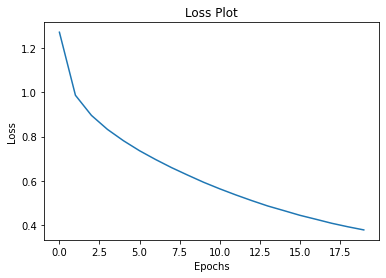

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Caption

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

array([  3,   2,  17,   9,   2,  10,  18,  33,  38,   2, 134, 289,  76,
         2, 113,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

Real Caption: <start> boy in black shorts sliding on black surface covered with water with green trees in the background <end>
Prediction Caption: a little girl in jeans standing in a park in a body of water and in water and jumping into a park in the background <end>


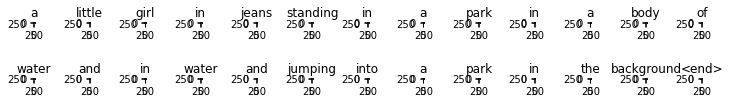

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Try it on your own images

Prediction Caption: a lone surfboarder catching a wave <end>


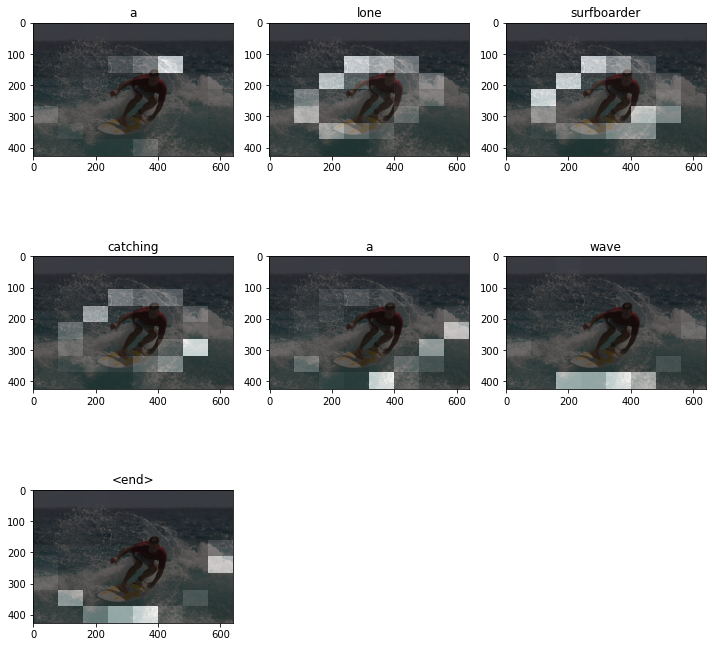

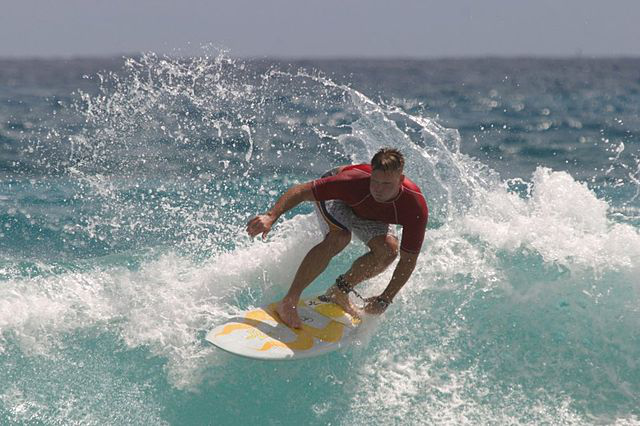

In [ ]:
#image_url = 'https://tensorflow.org/images/surf.jpg'
image_url ='https://static.toiimg.com/thumb/msid-60132235,imgsize-169468,width-800,height-600,resizemode-75/60132235.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

#Blue- Rougue Score

In [ ]:
!pip install torchtext==0.6.0
#!pip install py-rouge

     |████████████████████████████████| 71kB 5.7MB/s 
     |████████████████████████████████| 1.1MB 11.2MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [ ]:
import numpy as np
from nltk import ngrams
from collections import Counter
from torchtext.data.metrics import bleu_score

In [ ]:
#from torchtext.data.metrics import bleu_score

def calculate_bleu(data):
    trgs = []
    pred_trgs = []

    nltk_score = []
    nltk_corpus_score = []
    for index, row in data.iterrows():
     
      src_trg_1 = row['Actual Caption']
      src_trg = nltk.word_tokenize(src_trg_1)
      
      pred_trg_1 = row['Predicted Caption']
      pred_trg = nltk.word_tokenize(pred_trg_1)

      #cut off <eos> token
      pred_trg = pred_trg[:-3]
         
      pred_trgs.append(pred_trg)
      trgs.append([src_trg])

      sc = nltk.translate.bleu_score.sentence_bleu([src_trg], pred_trg)
      sc_1 = nltk.translate.bleu_score.corpus_bleu([[src_trg]], [pred_trg])
      
      nltk_score.append(sc)
      nltk_corpus_score.append(sc_1)
    
    score_avg = np.sum(nltk_score)/len(nltk_score)
    score_avg_corpus = np.sum(nltk_corpus_score)/len(nltk_corpus_score)

    return bleu_score(pred_trgs, trgs) , score_avg , score_avg_corpus , nltk_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import nltk.translate.bleu_score as bleu

In [ ]:
# captions on the validation set
real_caption_list=[]
predicted_caption_list=[]

for img in range(len(img_name_val)):
  image = img_name_val[img]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[img] if i not in [0]])
  result, attention_plot = evaluate(image)
 # print(real_caption)
  #Append
  real_caption_list.append(real_caption)
  predicted_caption_list.append(' '.join(result))  

real_caption_list
predicted_caption_list

['a man in a red <unk> stands slightly for the photo <end>',
 'a man wearing all and gold <unk> play with the band <unk> <unk> <end>',
 'a man plays ballplayer in full of band <end>',
 'a man wearing a red and yellow is running as another player <unk> <unk> <unk> and black <unk> <unk> and hat <end>',
 'a man is playing a bagpipe and wearing hawaiian and red and white <end>',
 'three dogs run after the ground for the tree with two standing on the grass <end>',
 'two people running to on the grass <end>',
 'three people stands by <end>',
 'two dogs playing with the <unk> <end>',
 'a dog is looking back to a tree and playing outside <end>',
 'man in jeans hangs off of rocks <end>',
 'a man in a white shirt is rock climbing underneath <end>',
 'man wearing no shirt shorts is rock climbing <end>',
 'man in short shorts is rock climbing over <unk> <end>',
 'man in a blue shirt hangs off of rocks <end>',
 'a black and tan dog runs through a forest <end>',
 'the brown dog jumps high out <end>'

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import nltk
dict_act_pred = {'Actual Caption': real_caption_list, 'Predicted Caption': predicted_caption_list}  
    
Dataframe_Actual_Predicted = pd.DataFrame(dict_act_pred) 

Dataframe_Actual_Predicted.to_excel ('Validation_Actual_Predicted.xlsx', index = False, header=True)
Dataframe_Actual_Predicted  

,Actual Caption,Predicted Caption
0,<start> a grey bearded scottish gentleman in r...,a man in a red <unk> stands slightly for the p...
1,<start> a man with a beard in the foreground p...,a man wearing all and gold <unk> play with the...
2,<start> a parade of bagpipers walk through a c...,a man plays ballplayer in full of band <end>
3,<start> several bagpipers in scottish dress <end>,a man wearing a red and yellow is running as a...
4,<start> the man with the white beard is playin...,a man is playing a bagpipe and wearing hawaiia...
...,...,...
8090,<start> a couple dogs in and around a small la...,two many dogs play in the water <end>
8091,<start> a couple of dogs are playing in the wa...,a black dog are in the water and in the water ...
8092,<start> two dogs play in the water under a bri...,several a black dog and another dog are in the...
8093,<start> two dogs running near a river while on...,a black dog and a black dog are outside in the...


In [ ]:
#os.getcwd()
import pandas as pd
Dataframe_Actual_Predicted= pd.read_excel('Validation_Actual_Predicted.xlsx')
Dataframe_Actual_Predicted

,Actual Caption,Predicted Caption
0,<start> a grey bearded scottish gentleman in r...,a man in a red <unk> stands slightly for the p...
1,<start> a man with a beard in the foreground p...,a man wearing all and gold <unk> play with the...
2,<start> a parade of bagpipers walk through a c...,a man plays ballplayer in full of band <end>
3,<start> several bagpipers in scottish dress <end>,a man wearing a red and yellow is running as a...
4,<start> the man with the white beard is playin...,a man is playing a bagpipe and wearing hawaiia...
...,...,...
8090,<start> a couple dogs in and around a small la...,two many dogs play in the water <end>
8091,<start> a couple of dogs are playing in the wa...,a black dog are in the water and in the water ...
8092,<start> two dogs play in the water under a bri...,several a black dog and another dog are in the...
8093,<start> two dogs running near a river while on...,a black dog and a black dog are outside in the...


In [ ]:
#return bleu_score(pred_trgs, trgs) , score_avg , score_avg_corpus , nltk_score
bleu_score_torch, avg_nltk_sentence_bleu_score , avg_nltk_corpus_bleu_score, nltk_score_list = calculate_bleu(Dataframe_Actual_Predicted)

print(f'BLEU score = {bleu_score_torch*100:.2f}')

print(f'BLEU score_NLTK = {avg_nltk_sentence_bleu_score:.2f}')

print(f'BLEU score_NLTK_CORPUS = {avg_nltk_corpus_bleu_score:.2f}')

BLEU score = 1.61
BLEU score_NLTK = 0.28
BLEU score_NLTK_CORPUS = 0.28


In [ ]:
!pip install rouge

In [ ]:

from rouge import Rouge

rouge = Rouge()

def calculate_rogue(data):
  rogue_scores = []
  for index, row in data.iterrows():
    
    src_trg = row['Actual Caption']
    pred_trg_1 = row['Predicted Caption']

    
    #cut off <eos> token
    pred_trg = pred_trg_1[:-6]

    if(len(pred_trg) != 0):
      sc = rouge.get_scores(pred_trg, src_trg, avg= True)
      rogue_scores.append(sc)
    
  return rogue_scores

In [ ]:
def get_rouge_1_scores(score):
  f_scores = []
  p_scores = []
  r_scores = []
  #print(score)
  for s in score:
    f_scores.append(s['rouge-1']['f'])
    p_scores.append(s['rouge-1']['p'])
    r_scores.append(s['rouge-1']['r'])
  
  return f_scores, p_scores, r_scores

In [ ]:
score_rogue = calculate_rogue(Dataframe_Actual_Predicted)
#score_rogue

f_rogue, p_rogue , r_rogue = get_rouge_1_scores(score_rogue)


Plot: Code to show how many were exactly matched or how many got rouge score greater than some threshold

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_1(data, xlabel, ylabel, title):
  values, base = np.histogram(data, bins=40)
  cumulative = np.cumsum(values)
  perc = cumulative/80 ##(check the length and divide by that *100)
  
  # plot the cumulative function
  plt.plot(perc,base[:-1], c='blue')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  
  plt.show()

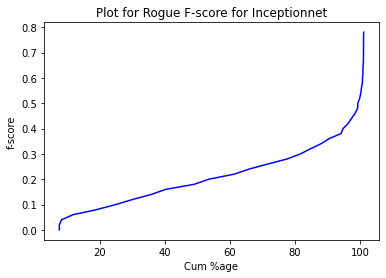

In [ ]:
plot_1(f_rogue, "Cum %age", "f-score", "Plot for Rogue F-score for Inceptionnet") 


In [ ]:
def examples_print(f_data, data, threshold = 0.9):
  for i in range(0,len(f_data)):
  #print(i)
    if f_data[i] > threshold:
      print('Caption Index: ',i)
      print('Actual Caption:  ',data.iloc[i]['Actual Caption'])
      print('Predicted Caption:  ',data.iloc[i]['Predicted Caption'])
      print('\n')

In [ ]:
len(f_rogue)/5

1618.8

In [ ]:
examples_print(f_rogue, Dataframe_Actual_Predicted, 0.7)

Caption Index:  632
Actual Caption:   <start> two dogs play in the surf <end>
Predicted Caption:   two black dogs play in the surf <end>


Caption Index:  4448
Actual Caption:   <start> a dog standing in water <end>
Predicted Caption:   a brown and tan dog is running through the water with a body of the water <end>


Caption Index:  5957
Actual Caption:   <start> a male dressed in a sports outfit tries to catch a baseball <end>
Predicted Caption:   a baseball player up a bat at a pitch at an action <end>


Caption Index:  6423
Actual Caption:   <start> a small white and black dog jumping in the snow <end>
Predicted Caption:   a black dog is running through the snow at a field of the snow <end>


Caption Index:  6894
Actual Caption:   <start> skier in red skiing down a snowy mountain <end>
Predicted Caption:   a person is skiing down the snow in snow <end>


Caption Index:  6896
Actual Caption:   <start> a black labrador bounds across the snow <end>
Predicted Caption:   a black dog is r

In [ ]:
print('Rogue Score',np.sum(f_rogue)/len(f_rogue))

Rogue Score: 0.21693037070904758
